# 🔧 Notebook Setup for 3-Class DistilBERT Fine-Tuning

This notebook sets up the environment to run the DistilBERT 3-class sentiment classification model from within a subdirectory (`notebooks/fine_tuning/fine_tuning_3class/`).

To ensure consistent paths (especially for model saving/loading), we manually add the project root to `sys.path`, so imports and relative paths from `src/` and `saved_models/` work as expected.


In [1]:
# cell 1
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display, HTML, clear_output

In [2]:
import torch

if torch.backends.mps.is_available():
    print("✅ MPS (Apple GPU) is available")
else:
    print("❌ MPS not available")


✅ MPS (Apple GPU) is available


In [3]:
import sys
for path in sys.path:
    print(path)


/Users/afshinpaydar/Projects/Thesis/notebooks/fine_tuning/fine_tuning_3class
/opt/anaconda3/lib/python312.zip
/opt/anaconda3/lib/python3.12
/opt/anaconda3/lib/python3.12/lib-dynload

/opt/anaconda3/lib/python3.12/site-packages
/opt/anaconda3/lib/python3.12/site-packages/aeosa
/opt/anaconda3/lib/python3.12/site-packages/setuptools/_vendor


In [4]:
import os
import sys
from pathlib import Path

# Dynamically detect and add the project root to sys.path
def find_project_root(start=Path.cwd()):
    for path in [start] + list(start.parents):
        if (path / "src").is_dir():
            return path
    raise FileNotFoundError("❌ Could not locate 'src/' directory.")

project_root = find_project_root()
sys.path.insert(0, str(project_root))  # insert at the beginning to prioritize it

print(f"✅ Project root added to sys.path: {project_root}")


✅ Project root added to sys.path: /Users/afshinpaydar/Projects/Thesis


Starting fine-tuning process...
[INFO] Initializing DistilBERT 3-class fine-tuner with model: distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

[INFO] Tokenizer loaded successfully.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Model distilbert-base-uncased initialized with 3 labels.
[INFO] Model moved to device: mps
[INFO] Data module initialized.
[INFO] Using class weights: [1.4208103  0.67049855 1.2426239 ]
[INFO] Model initialized on device: mps
[INFO] Optimizer: AdamW with learning rate 1e-05
[INFO] ModelTrainer initialized.

[INFO] Starting DistilBERT 3-class fine-tuning process.
[INFO] Loading dataset...
[INFO] Loaded dataset with 16973 samples.
[INFO] Creating dataloaders...
[INFO] Dataloaders created.

[INFO] Starting training...
[INFO] Model running on: mps:0
[INFO] Training started for 5 epochs.


Training Batches: 100%|██████████████████████████████| 398/398 [04:39<00:00,  1.18it/s, loss=0.4894, avg_loss=0.3598]
                                                                                                                     
Evaluating: 100%|███████████████████████████████████████████████████████| 80/80 [00:24<00:00,  3.49it/s, loss=0.1950]
Epoch 1/5 - Loss: 0.5420 - Val Loss: 0.3322 - Val Acc: 0.8735 - Val F1: 0.8737:   0%|          | 0/5 [05:04<?, ?it/s]


⏱️  Epoch: 1/5
📊 Training   | Loss: 0.5420
📊 Validation | Loss: 0.3322 | Accuracy: 0.8735 | F1 Score: 0.8737



Epoch 1/5 - Loss: 0.5420 - Val Loss: 0.3322 - Val Acc: 0.8735 - Val F1: 0.8737:  20%|▏| 1/5 [05:08<20:35, 308.78s/it]

📈 New best model saved!



Training Batches:  99%|█████████████████████████████▊| 396/398 [05:41<00:01,  1.06it/s, loss=0.1970, avg_loss=0.2469]
                                                                                                                     
Evaluating: 100%|███████████████████████████████████████████████████████| 80/80 [00:26<00:00,  3.27it/s, loss=0.1526]
Epoch 2/5 - Loss: 0.2984 - Val Loss: 0.3145 - Val Acc: 0.8806 - Val F1: 0.8806:  20%|▏| 1/5 [11:16<20:35, 308.78s/it]


⏱️  Epoch: 2/5
📊 Training   | Loss: 0.2984
📊 Validation | Loss: 0.3145 | Accuracy: 0.8806 | F1 Score: 0.8806



Epoch 2/5 - Loss: 0.2984 - Val Loss: 0.3145 - Val Acc: 0.8806 - Val F1: 0.8806:  40%|▍| 2/5 [11:20<17:17, 345.90s/it]

📈 New best model saved!



Training Batches:  99%|█████████████████████████████▊| 396/398 [06:00<00:01,  1.06it/s, loss=0.4678, avg_loss=0.2697]
                                                                                                                     
Evaluating: 100%|███████████████████████████████████████████████████████| 80/80 [00:28<00:00,  3.06it/s, loss=0.1474]
Epoch 3/5 - Loss: 0.2421 - Val Loss: 0.3216 - Val Acc: 0.8755 - Val F1: 0.8760:  60%|▌| 3/5 [17:49<12:10, 365.39s/it]


⏱️  Epoch: 3/5
📊 Training   | Loss: 0.2421
📊 Validation | Loss: 0.3216 | Accuracy: 0.8755 | F1 Score: 0.8760




Training Batches: 100%|██████████████████████████████| 398/398 [06:06<00:00,  1.10it/s, loss=0.2092, avg_loss=0.1888]
                                                                                                                     
Evaluating: 100%|███████████████████████████████████████████████████████| 80/80 [00:27<00:00,  3.25it/s, loss=0.1403]
Epoch 4/5 - Loss: 0.2081 - Val Loss: 0.3371 - Val Acc: 0.8833 - Val F1: 0.8832:  60%|▌| 3/5 [24:22<12:10, 365.39s/it]


⏱️  Epoch: 4/5
📊 Training   | Loss: 0.2081
📊 Validation | Loss: 0.3371 | Accuracy: 0.8833 | F1 Score: 0.8832



Epoch 4/5 - Loss: 0.2081 - Val Loss: 0.3371 - Val Acc: 0.8833 - Val F1: 0.8832:  80%|▊| 4/5 [24:26<06:17, 377.98s/it]

📈 New best model saved!



Training Batches: 100%|█████████████████████████████▉| 397/398 [06:11<00:01,  1.11s/it, loss=0.1896, avg_loss=0.1365]
                                                                                                                     
Evaluating: 100%|███████████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.76it/s, loss=0.1528]
Epoch 5/5 - Loss: 0.1841 - Val Loss: 0.3284 - Val Acc: 0.8826 - Val F1: 0.8827: 100%|█| 5/5 [31:10<00:00, 374.06s/it]



⏱️  Epoch: 5/5
📊 Training   | Loss: 0.1841
📊 Validation | Loss: 0.3284 | Accuracy: 0.8826 | F1 Score: 0.8827

✅ Training complete!


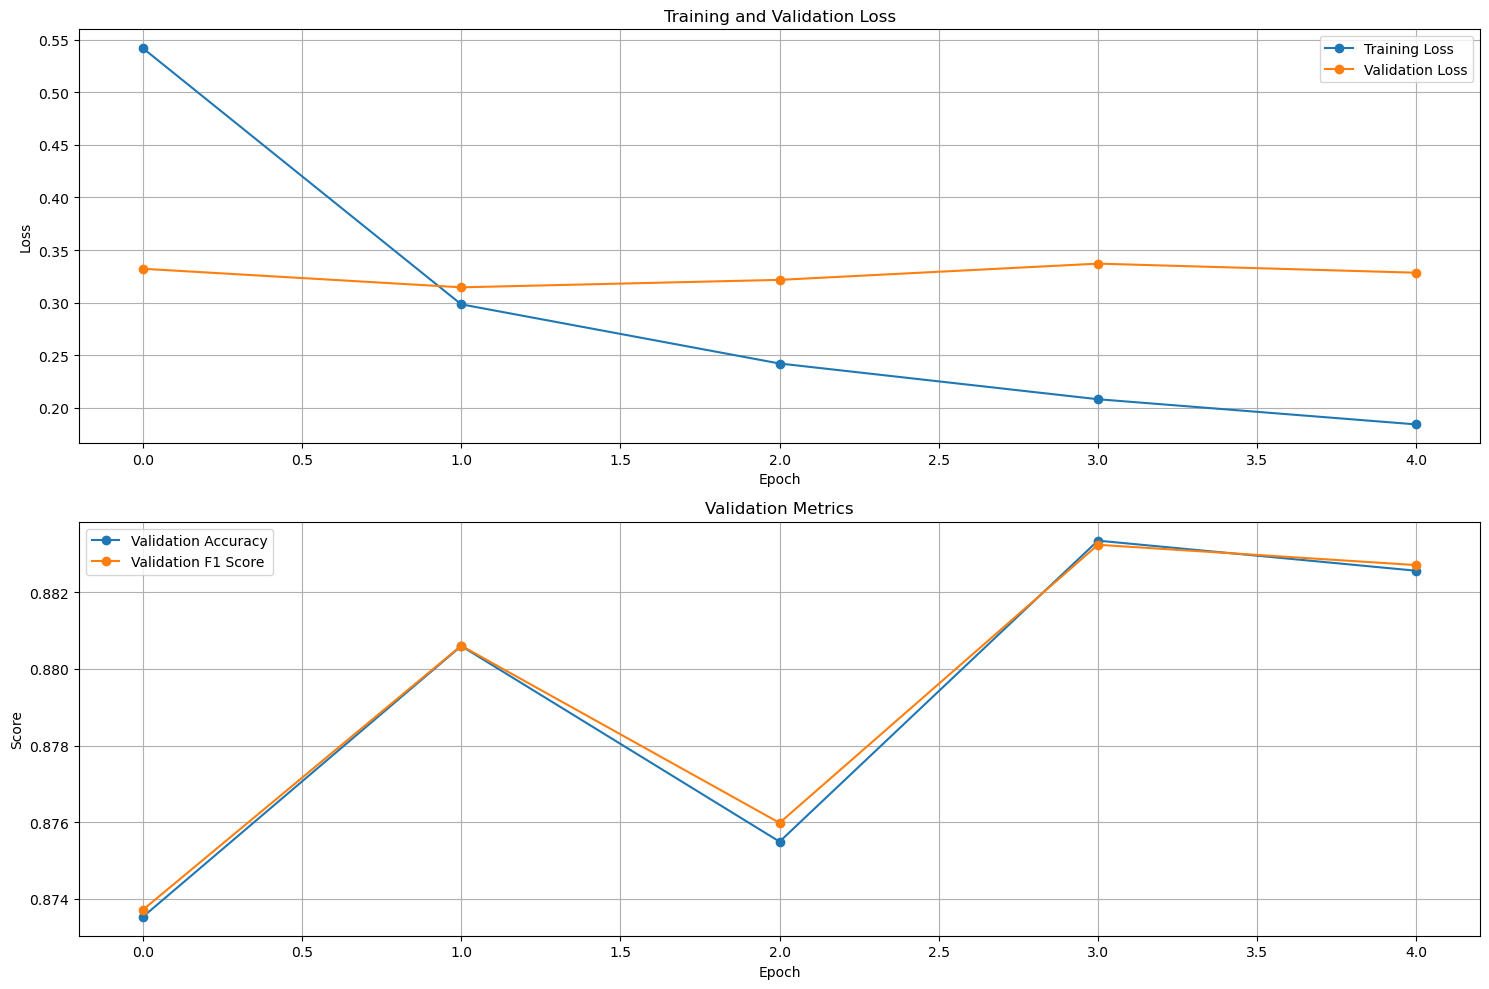

[INFO] Training complete.
[INFO] Evaluating model...
[INFO] Initializing model evaluator...
[INFO] Running evaluation...
[INFO] Evaluating model on 54 batches...
[INFO] Evaluation complete. Processed 1698 samples.
[INFO] Calculating metrics...
[INFO] Metrics calculated. Overall accuracy: 0.8740
[INFO] Generating evaluation report at /Users/afshinpaydar/Projects/Thesis/saved_models/codebert_3class/evaluation_result_codebert...
[INFO] Evaluation report saved as '/Users/afshinpaydar/Projects/Thesis/saved_models/codebert_3class/evaluation_result_codebert'
[INFO] Calculating metrics...
[INFO] Metrics calculated. Overall accuracy: 0.8740
[INFO] Evaluation report generated at /Users/afshinpaydar/Projects/Thesis/saved_models/codebert_3class/evaluation_result_codebert
[INFO] Model evaluation metrics: {'accuracy': 0.8739693757361602, 'precision': 0.864389862253553, 'recall': 0.8808326868940487, 'f1': 0.8717112111640999, 'per_class': {'Negative': {'precision': 0.823943661971831, 'recall': 0.87969

In [5]:
# cell 3
from src.models.distilbert_3class.train_distilbert_3class import main

# Run the main function and capture the returned fine_tuner instance
print("Starting fine-tuning process...")
fine_tuner = main()
print("Fine-tuning process completed!")

Final Evaluation Metrics:


,Metric,Value
0,accuracy,0.873969
1,precision,0.86439
2,recall,0.880833
3,f1,0.871711
4,per_class,"{'Negative': {'precision': 0.823943661971831, ..."
5,confusion_matrix,"[[351, 41, 7], [65, 718, 61], [10, 30, 415]]"


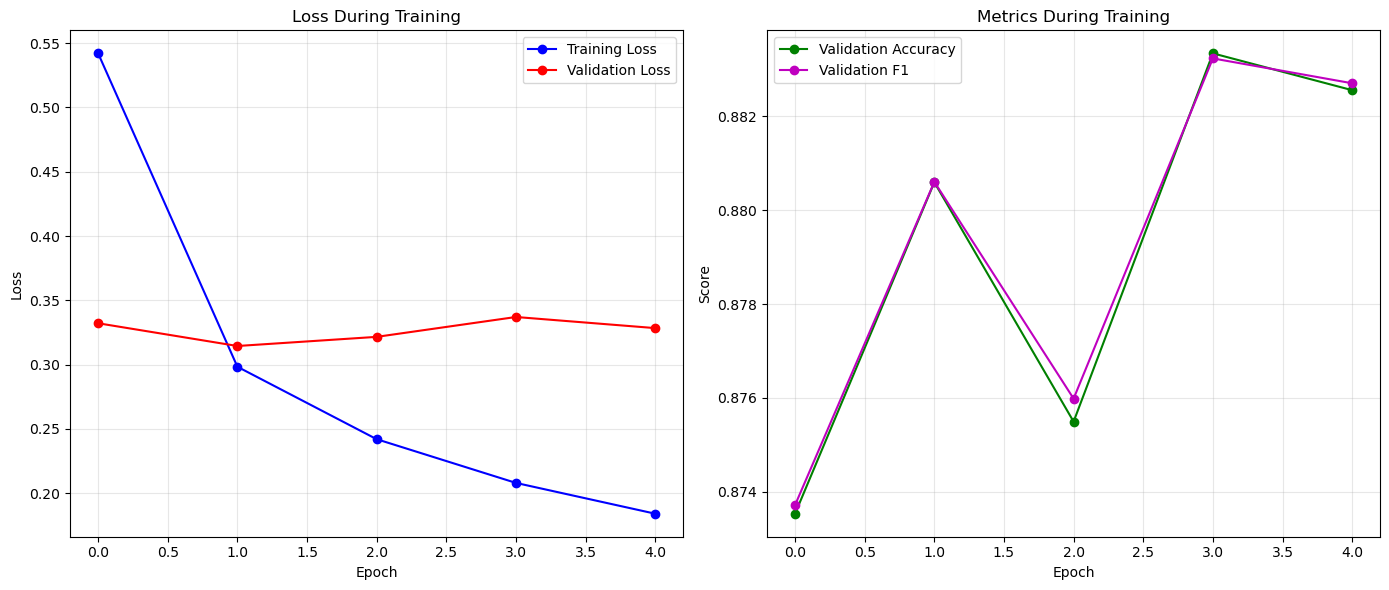

In [6]:
# Cell 4: View Training Results
    
# Display metrics if available
if hasattr(fine_tuner, 'metrics'):
    print("Final Evaluation Metrics:")
    metrics_df = pd.DataFrame([fine_tuner.metrics])
    display(metrics_df.T.reset_index().rename(columns={'index': 'Metric', 0: 'Value'}))
# Visualize training history if available
if hasattr(fine_tuner.trainer, 'history') and fine_tuner.trainer.history:
    history = fine_tuner.trainer.history
    if history.get('train_loss') and history.get('val_loss'):
        # Create figure
        plt.figure(figsize=(14, 6))
        # Plot training and validation loss
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], 'b-o', label='Training Loss')
        plt.plot(history['val_loss'], 'r-o', label='Validation Loss')
        plt.title('Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        # Plot performance metrics
        plt.subplot(1, 2, 2)
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], 'g-o', label='Validation Accuracy')
        if 'val_f1' in history:
            # Fix: Change 'p-o' to 'm-o' (magenta instead of purple)
            plt.plot(history['val_f1'], 'm-o', label='Validation F1')
        plt.title('Metrics During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("No training history available.")

Loading test dataset...
✅ Test dataset loaded with 1698 samples.
Running comprehensive evaluation...
[INFO] Evaluating model on 54 batches...
[INFO] Evaluation complete. Processed 1698 samples.
[INFO] Calculating metrics...
[INFO] Metrics calculated. Overall accuracy: 0.8740
Saving predictions with confidence scores...
📄 Saved test set predictions to: /Users/afshinpaydar/Desktop/temp/Thesis/saved_models/evaluation_results/test_predictions_with_confidence_v02_27032025.csv


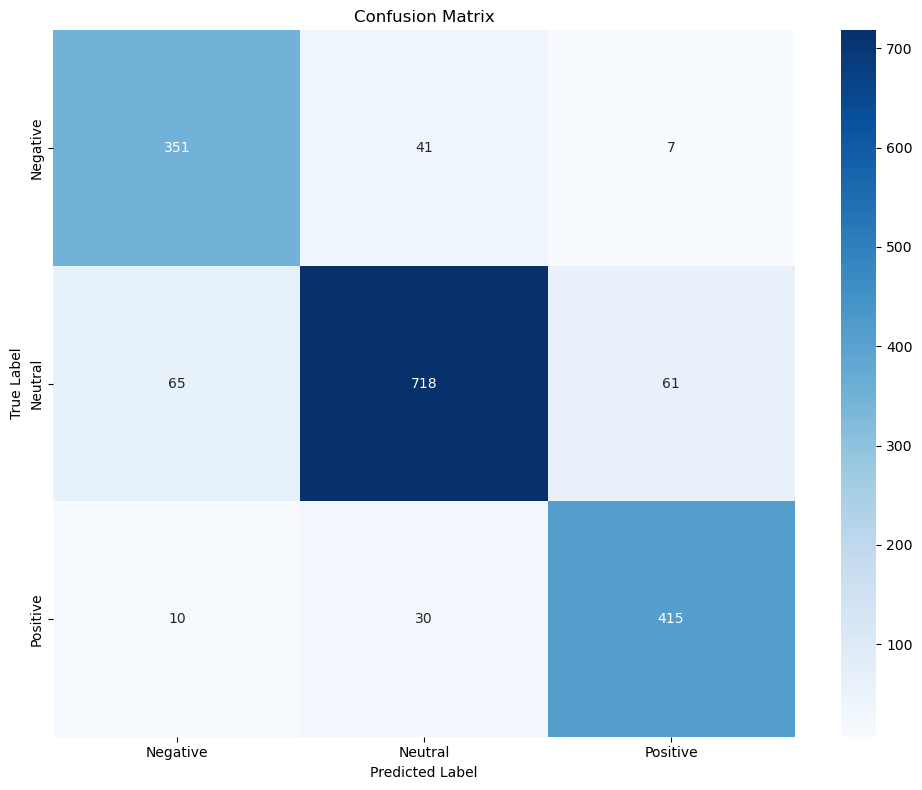


Classification Report:


,Precision,Recall,F1 Score,Accuracy
0,0.86439,0.880833,0.871711,0.873969



Per-Class Performance:


,precision,recall,f1-score,support
Negative,0.823944,0.879699,0.850909,399.0
Neutral,0.910013,0.850711,0.879363,844.0
Positive,0.859213,0.912088,0.884861,455.0


In [7]:
# Cell 5: Run Comprehensive Evaluation + Save Predictions with Confidence
try:
    from IPython.display import display, HTML
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    from pathlib import Path
    from src.training.model_evaluator import ModelEvaluator
    from src.config_three_class import CONFIG_3CLASS as CONFIG
    
    display(HTML("<div class='section-header'>Model Evaluation</div>"))
    
    # Get test data
    print("Loading test dataset...")
    texts, labels = fine_tuner.data_module.load_dataset()
    _, _, test_loader = fine_tuner.data_module.create_dataloaders(texts, labels)
    print(f"✅ Test dataset loaded with {len(test_loader.dataset)} samples.")
    
    # Run evaluation
    print("Running comprehensive evaluation...")
    evaluator = ModelEvaluator(
        model=fine_tuner.model,
        device=fine_tuner.device,
        model_name="DistilBERT 3-Class Sentiment Classifier",
        class_names=fine_tuner.class_names
    )
    
    all_labels, all_preds, all_probs = evaluator.evaluate(test_loader)
    metrics = evaluator.calculate_metrics(all_labels, all_preds, all_probs)
    
    # Save full prediction results with confidence
    print("Saving predictions with confidence scores...")
    output_df = pd.DataFrame({
        "message": texts[-len(all_labels):],  # match the test set
        "true_label": [fine_tuner.class_names[label] for label in all_labels],
        "predicted_label": [fine_tuner.class_names[pred] for pred in all_preds],
        "true_index": all_labels,
        "predicted_index": all_preds,
        "confidence": [max(prob) for prob in all_probs]
    })

    output_path = Path("/Users/afshinpaydar/Desktop/temp/Thesis/saved_models/evaluation_results/test_predictions_with_confidence_v02_27032025.csv")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    output_df.to_csv(output_path, index=False)
    print(f"📄 Saved test set predictions to: {output_path}")
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = metrics["confusion_matrix"]
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=fine_tuner.class_names,
        yticklabels=fine_tuner.class_names
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()
    
    # Summary classification metrics
    print("\nClassification Report:")
    metrics_df = pd.DataFrame({
        'Precision': [metrics['precision']],
        'Recall': [metrics['recall']],
        'F1 Score': [metrics['f1']],
        'Accuracy': [metrics['accuracy']]
    })
    display(metrics_df)
    
    # Per-class metrics
    if 'per_class' in metrics:
        print("\nPer-Class Performance:")
        per_class_df = pd.DataFrame(metrics['per_class']).T
        display(per_class_df)

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()


In [8]:
# Cell 6: Error Analysis – Save Misclassified Predictions
import pandas as pd
from pathlib import Path
from src.config_three_class import CONFIG_3CLASS as CONFIG  # ✅ correct config

try:
    # Load and clean the raw dataset
    df_raw = pd.read_csv(CONFIG["dataset"]["dataset_path"])
    df_raw = df_raw.dropna(subset=["message"]).drop_duplicates(subset=["message"]).reset_index(drop=True)

    # Map labels: -1 → 0, 0 → 1, 1 → 2
    label_map = {-1: 0, 0: 1, 1: 2}
    df_raw["mapped_label"] = df_raw["sentiment"].map(label_map)

    # Load data split (only test set)
    texts, labels = fine_tuner.data_module.load_dataset()
    _, _, test_loader = fine_tuner.data_module.create_dataloaders(texts, labels)

    # Extract test texts from test_loader (guaranteed correct order)
    test_texts = [batch["input_ids"] for batch in test_loader]
    test_indices = test_loader.dataset.indices if hasattr(test_loader.dataset, 'indices') else list(test_loader.dataset)

    # Slice original cleaned texts to test set size
    test_texts = [texts[i] for i in range(len(test_loader.dataset))]

    # Evaluate if needed
    if 'all_preds' not in globals() or 'all_labels' not in globals():
        all_labels, all_preds, all_probs = evaluator.evaluate(test_loader)

    # Build DataFrame
    error_df = pd.DataFrame({
        "message": test_texts,
        "true_label": [fine_tuner.class_names[label] for label in all_labels],
        "predicted_label": [fine_tuner.class_names[pred] for pred in all_preds],
        "true_index": all_labels,
        "predicted_index": all_preds
    })

    # Find misclassified rows
    misclassified = error_df[error_df["true_index"] != error_df["predicted_index"]]

    # Save
    output_path = CONFIG["evaluation"]["report_save_path"]
    output_path.parent.mkdir(parents=True, exist_ok=True)
    misclassified.to_csv(output_path, index=False)

    print(f"❌ Saved {len(misclassified)} misclassified examples to: {output_path}")

except Exception as e:
    print("⚠️ Error during misclassification analysis:")
    import traceback
    traceback.print_exc()


⚠️ Error during misclassification analysis:


Traceback (most recent call last):
  File "/var/folders/yf/fm096zz15bqc6vfl0tpmffg80000gn/T/ipykernel_71830/1070219549.py", line 44, in <module>
    output_path.parent.mkdir(parents=True, exist_ok=True)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'str' object has no attribute 'parent'


In [10]:
# cell 7
import os
from IPython.display import HTML, display
from src.config_three_class import CONFIG_3CLASS as CONFIG 

# Cell 6: Generate PDF Report
try:
    display(HTML("<div class='section-header'>Generate Evaluation Report</div>"))
    
    # Use path from config
    report_path =  "/Users/afshinpaydar/Projects/Thesis/saved_models/distilbert/evaluation_result"
    os.makedirs(os.path.dirname(report_path), exist_ok=True)
    
    print(f"Generating comprehensive PDF report at {report_path}...")
    evaluator.generate_pdf_report(all_labels, all_preds, all_probs, output_path=report_path)
    print(f"✅ PDF report generated successfully at: {report_path}")
    
except Exception as e:
    print(f"❌ An error occurred: {e}")
    import traceback
    traceback.print_exc()


Generating comprehensive PDF report at /Users/afshinpaydar/Projects/Thesis/saved_models/distilbert/evaluation_result...
[INFO] Calculating metrics...
[INFO] Metrics calculated. Overall accuracy: 0.8740
[INFO] Generating evaluation report at /Users/afshinpaydar/Projects/Thesis/saved_models/distilbert/evaluation_result...
[INFO] Evaluation report saved as '/Users/afshinpaydar/Projects/Thesis/saved_models/distilbert/evaluation_result'
✅ PDF report generated successfully at: /Users/afshinpaydar/Projects/Thesis/saved_models/distilbert/evaluation_result


In [ ]:
# cell 8
import torch
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout
from src.config_three_class import CONFIG_3CLASS as CONFIG  # ✅ Use 3-class config

# Cell 7: Test with Custom Inputs (Optional)
try:
    # Display header
    display(HTML("<div class='section-header'>Test with Custom Inputs</div>"))
    
    def predict_sentiment(text):
        """Function to predict sentiment of a given text"""
        inputs = fine_tuner.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=CONFIG["training"]["max_length"]
        )
        inputs = {key: val.to(fine_tuner.device) for key, val in inputs.items()}
        fine_tuner.model.eval()

        with torch.no_grad():
            outputs = fine_tuner.model(**inputs)
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            prediction = torch.argmax(logits, dim=1)

        predicted_class = fine_tuner.class_names[prediction.item()]
        confidence = probabilities[0][prediction.item()].item() * 100

        class_probs = {
            fine_tuner.class_names[i]: prob.item() * 100 
            for i, prob in enumerate(probabilities[0])
        }
        
        return predicted_class, confidence, class_probs
    
    # UI
    text_input = widgets.Textarea(
        placeholder='Enter text to analyze...',
        layout=Layout(width='100%', height='100px')
    )
    
    button = widgets.Button(
        description='Analyze Sentiment',
        button_style='primary',
        layout=Layout(width='200px')
    )
    
    output = widgets.Output()
    
    def on_button_click(b):
        with output:
            clear_output()
            if not text_input.value.strip():
                print("Please enter some text to analyze.")
                return
            
            print(f"Analyzing: \"{text_input.value}\"")
            predicted_class, confidence, class_probs = predict_sentiment(text_input.value)
            
            print(f"\nPredicted sentiment: {predicted_class} (Confidence: {confidence:.2f}%)")
            print("\nProbabilities for all classes:")
            for cls, prob in class_probs.items():
                print(f"  - {cls}: {prob:.2f}%")
    
    button.on_click(on_button_click)
    
    print("Try your own examples:")
    display(text_input)
    display(button)
    display(output)
    
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()


In [12]:
# Cell: Save trained model, tokenizer, and training config
import os
import json
from datetime import datetime
import numpy as np  # required for converting arrays
from src.config_three_class import CONFIG_3CLASS as CONFIG 


# === Paths ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"saved_models/distilbert_3class_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

# === Save model + tokenizer (HuggingFace format) ===
fine_tuner.model.save_pretrained(save_dir)
fine_tuner.tokenizer.save_pretrained(save_dir)
print(f"✅ Model + tokenizer saved to: {save_dir}")

# === Safely convert non-serializable objects ===
def safe_convert(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, torch.device):
        return str(obj)
    raise TypeError(f"Object of type {type(obj).__name__} is not JSON serializable")

# === Save custom training config snapshot ===
config_snapshot = {
    "model_name": CONFIG["models"]["distilbert"]["pretrained_model_name"],
    "class_names": CONFIG["dataset"]["class_names"],
    "num_labels": CONFIG["dataset"]["num_labels"],
    "training_config": CONFIG["training"],
    "dataset_config": {
        k: v for k, v in CONFIG["dataset"].items()
        if "raw" not in k  # exclude raw paths to keep config portable
    },
    "metrics": fine_tuner.metrics if hasattr(fine_tuner, 'metrics') else None,
    "timestamp": timestamp
}

# Dump to JSON
with open(os.path.join(save_dir, "config_custom.json"), "w") as f:
    json.dump(config_snapshot, f, indent=4, default=safe_convert)

print(f"📄 Custom training config saved at: {os.path.join(save_dir, 'config_custom.json')}")


✅ Model + tokenizer saved to: saved_models/distilbert_3class_20250327_235150
📄 Custom training config saved at: saved_models/distilbert_3class_20250327_235150/config_custom.json


In [21]:
from transformers import (
    DistilBertForSequenceClassification, 
    DistilBertTokenizerFast
)
import torch

# Step 1: Initialize DistilBERT for 3-class classification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased", num_labels=3)
# Step 2: Load your best model checkpoint
checkpoint_path = "/Users/afshinpaydar/Projects/Thesis/saved_models/checkpoint_distilbert_f1-0.8832_epoch-4.pt"  
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/yf/fm096zz15bqc6vfl0tpmffg80000gn/T/ipykernel_71830/2214414150.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this

<All keys matched successfully>

Loading test dataset...
✅ Test dataset loaded with 1698 samples.
Running comprehensive evaluation...
[INFO] Evaluating model on 54 batches...
[INFO] Evaluation complete. Processed 1698 samples.
[INFO] Calculating metrics...
[INFO] Metrics calculated. Overall accuracy: 0.8769
Saving predictions with confidence scores...
📄 Saved test set predictions to: saved_models/evaluation_results/test_predictions_best_model_89.54%.csv


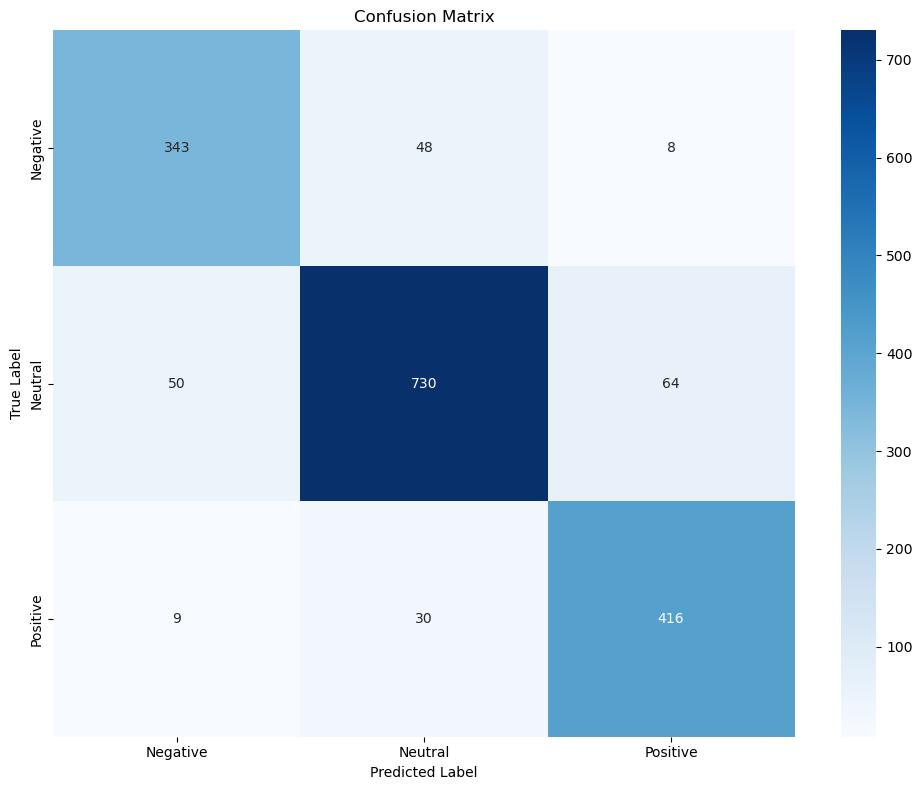


Classification Report:


,Precision,Recall,F1 Score,Accuracy
0,0.869719,0.879621,0.874166,0.876914



Per-Class Performance:


,precision,recall,f1-score,support
Negative,0.853234,0.859649,0.856429,399.0
Neutral,0.903465,0.864929,0.883777,844.0
Positive,0.852459,0.914286,0.882291,455.0


In [22]:
# Cell: Evaluate Loaded Model on Test Set
device = torch.device("cpu")  # Force CPU for stability (MPS has known bugs)

# Move model to device
model.to(device)

try:
    from IPython.display import display, HTML
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    from pathlib import Path
    from src.training.model_evaluator import ModelEvaluator
    from src.config_three_class import CONFIG_3CLASS as CONFIG
    from src.data_pipeline.data_loader import DataModule

    display(HTML("<div class='section-header'>Model Evaluation (Loaded Model)</div>"))

    # Initialize tokenizer-backed data module
    data_module = DataModule(tokenizer)

    print("Loading test dataset...")
    texts, labels = data_module.load_dataset()
    _, _, test_loader = data_module.create_dataloaders(texts, labels)
    print(f"✅ Test dataset loaded with {len(test_loader.dataset)} samples.")

    # Run evaluation
    print("Running comprehensive evaluation...")
    evaluator = ModelEvaluator(
        model=model,
        device=device,  # ✅ use the one we defined and applied to the model
        model_name="DistilBERT 3-Class Sentiment Classifier (Best)",
        class_names=CONFIG["dataset"]["class_names"]
    )

    all_labels, all_preds, all_probs = evaluator.evaluate(test_loader)
    metrics = evaluator.calculate_metrics(all_labels, all_preds, all_probs)

    # Save predictions with confidence
    print("Saving predictions with confidence scores...")
    output_df = pd.DataFrame({
        "message": texts[-len(all_labels):],
        "true_label": [CONFIG["dataset"]["class_names"][label] for label in all_labels],
        "predicted_label": [CONFIG["dataset"]["class_names"][pred] for pred in all_preds],
        "true_index": all_labels,
        "predicted_index": all_preds,
        "confidence": [max(prob) for prob in all_probs]
    })

    output_path = Path("saved_models/evaluation_results/test_predictions_best_model_89.54%.csv")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    output_df.to_csv(output_path, index=False)
    print(f"📄 Saved test set predictions to: {output_path}")

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = metrics["confusion_matrix"]
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=CONFIG["dataset"]["class_names"],
        yticklabels=CONFIG["dataset"]["class_names"]
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    # Summary classification metrics
    print("\nClassification Report:")
    metrics_df = pd.DataFrame({
        'Precision': [metrics['precision']],
        'Recall': [metrics['recall']],
        'F1 Score': [metrics['f1']],
        'Accuracy': [metrics['accuracy']]
    })
    display(metrics_df)

    # Per-class metrics
    if 'per_class' in metrics:
        print("\nPer-Class Performance:")
        per_class_df = pd.DataFrame(metrics['per_class']).T
        display(per_class_df)

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()


Loading test dataset...
✅ Test dataset loaded with 1698 samples.
Running comprehensive evaluation...
[INFO] Evaluating model on 54 batches...
[INFO] Evaluation complete. Processed 1698 samples.
[INFO] Calculating metrics...
[INFO] Metrics calculated. Overall accuracy: 0.8769
📄 Saved full predictions to: saved_models/evaluation_results/test_predictions_best_model.csv
❌ Saved 209 misclassified examples to: saved_models/evaluation_results/misclassified_predictions_08954.csv


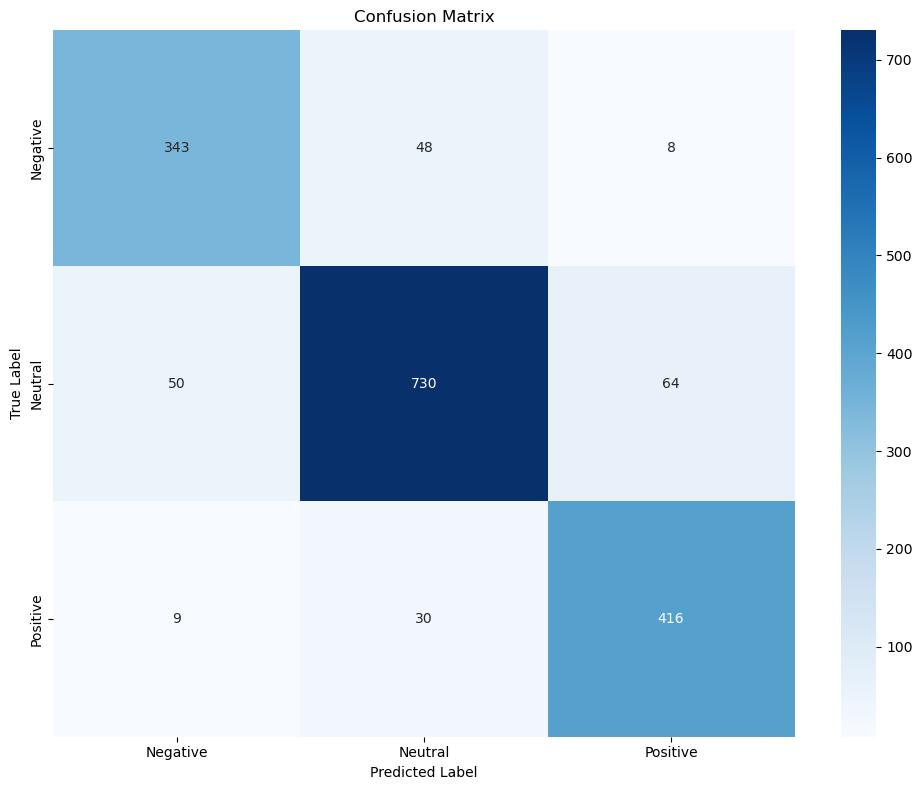


Classification Report:


,Precision,Recall,F1 Score,Accuracy
0,0.869719,0.879621,0.874166,0.876914



Per-Class Performance:


,precision,recall,f1-score,support
Negative,0.853234,0.859649,0.856429,399.0
Neutral,0.903465,0.864929,0.883777,844.0
Positive,0.852459,0.914286,0.882291,455.0


In [23]:
# Cell: Evaluate Loaded Model on Test Set + Save Misclassified
device = torch.device("cpu")  # Force CPU to avoid MPS issues
model.to(device)

try:
    from IPython.display import display, HTML
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    from pathlib import Path
    from src.training.model_evaluator import ModelEvaluator
    from src.config_three_class import CONFIG_3CLASS as CONFIG
    from src.data_pipeline.data_loader import DataModule

    display(HTML("<div class='section-header'>Model Evaluation (Loaded Model)</div>"))

    # Initialize tokenizer-backed data module
    data_module = DataModule(tokenizer)

    print("Loading test dataset...")
    texts, labels = data_module.load_dataset()
    _, _, test_loader = data_module.create_dataloaders(texts, labels)
    print(f"✅ Test dataset loaded with {len(test_loader.dataset)} samples.")

    # Run evaluation
    print("Running comprehensive evaluation...")
    evaluator = ModelEvaluator(
        model=model,
        device=device,
        model_name="DistilBERT 3-Class Sentiment Classifier (Best)",
        class_names=CONFIG["dataset"]["class_names"]
    )

    all_labels, all_preds, all_probs = evaluator.evaluate(test_loader)
    metrics = evaluator.calculate_metrics(all_labels, all_preds, all_probs)

    # Create DataFrame of predictions
    output_df = pd.DataFrame({
        "message": texts[-len(all_labels):],
        "true_label": [CONFIG["dataset"]["class_names"][label] for label in all_labels],
        "predicted_label": [CONFIG["dataset"]["class_names"][pred] for pred in all_preds],
        "true_index": all_labels,
        "predicted_index": all_preds,
        "confidence": [max(prob) for prob in all_probs]
    })

    # === Save all predictions ===
    full_output_path = Path("saved_models/evaluation_results/test_predictions_best_model.csv")
    full_output_path.parent.mkdir(parents=True, exist_ok=True)
    output_df.to_csv(full_output_path, index=False)
    print(f"📄 Saved full predictions to: {full_output_path}")

    # === Save only misclassified examples ===
    misclassified_df = output_df[output_df["true_index"] != output_df["predicted_index"]]
    error_path = Path("saved_models/evaluation_results/misclassified_predictions_08954.csv")
    misclassified_df.to_csv(error_path, index=False)
    print(f"❌ Saved {len(misclassified_df)} misclassified examples to: {error_path}")

    # === Confusion matrix ===
    plt.figure(figsize=(10, 8))
    cm = metrics["confusion_matrix"]
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=CONFIG["dataset"]["class_names"],
        yticklabels=CONFIG["dataset"]["class_names"]
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    # === Classification report ===
    print("\nClassification Report:")
    metrics_df = pd.DataFrame({
        'Precision': [metrics['precision']],
        'Recall': [metrics['recall']],
        'F1 Score': [metrics['f1']],
        'Accuracy': [metrics['accuracy']]
    })
    display(metrics_df)

    if 'per_class' in metrics:
        print("\nPer-Class Performance:")
        per_class_df = pd.DataFrame(metrics['per_class']).T
        display(per_class_df)

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()
